# Objective

Download and plot 1m DEM data from the USGS 3DEP program's 1m DEM database.

In [60]:
%matplotlib notebook
!ls *.xml

'USGS_Coastal QL2 Lidar with 3DEP Extension_DEM_IMG.xml'
 USGS_NED_one_meter_x21y350_MS_Coastal_3DEP_Extension_UTM16_2015_IMG_2018_meta.xml


In [61]:
import requests
from zipfile import ZipFile
import io
from io import BytesIO
from osgeo import gdal
#urlbase = 'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1m/Projects/MS_Coastal_Z15_2015/IMG/'
#zipfilename = 'USGS_NED_one_meter_x75y350_MS_Coastal_Z15_2015_IMG_2019.zip'
#download = requests.get(url=urlbase+zipfilename)

In [62]:
zipfile = ZipFile('USGS_NED_one_meter_x71y359_MS_NatchezTrace_2016_IMG_2018.zip')
img_filename = None
xml_filename = None
for f in zipfile.filelist:
    if '.img' in f.filename:
        img_filename = f.filename
    if 'meta.xml' in f.filename:
        xml_filename = f.filename
print("\nGetting DEM from:\n {0}".format(img_filename))
print("\nGetting DEM metadata from:\n {0}".format(xml_filename))


Getting DEM from:
 USGS_NED_one_meter_x71y359_MS_NatchezTrace_2016_IMG_2018.img

Getting DEM metadata from:
 USGS_NED_one_meter_x71y359_MS_NatchezTrace_2016_IMG_2018_meta.xml


In [63]:
import xml.etree.ElementTree as ET
f_xml = zipfile.open(xml_filename).read()
root = ET.fromstring(f_xml.decode())
for element in root.iter('*'):
    #print(element.tag)
    if element.tag == 'rowcount':
        nrows=int(element.text)
    if element.tag == 'colcount':
        ncols=int(element.text)
    if element.tag in ['westbc','eastbc','northbc','southbc']:
        print(element.text)
        if element.tag == 'westbc':
            west = float(element.text)
        if element.tag == 'northbc':
            north = float(element.text)
#print(nrows,ncols)
a = (709994.00000718, 3590007.000113518, 15, 'S')

-90.7666094839
-90.662517188
32.4274025527
32.3352155511


In [64]:
# GDAL does not use python exceptions by default
gdal.UseExceptions()
img_file_path = zipfile.extract(img_filename)

In [92]:
# GDAL does not use python exceptions by default
gdal.UseExceptions()
geo = gdal.Open(img_file_path)
drv = geo.GetDriver()
topo = geo.ReadAsArray()
x = geo.GetGeoTransform()[0]
y = geo.GetGeoTransform()[3]
print(a[0],a[1],x,y, a[0]-x, a[1]-y)

709994.00000718 3590007.000113518 709994.0 3590007.0 7.180031388998032e-06 0.00011351797729730606


In [66]:
from pyproj import Proj
myProj = Proj("+proj=utm +zone=15S, +north +datum=NAD83 +units=m +no_defs")
lon, lat = myProj(x, y, inverse=True)
print(lat,lon,north,west,lat-north,lon-west)

32.42740255184706 -90.76660948391722 32.4274025527 -90.7666094839 -8.529426054337819e-10 -1.722355591482483e-11


<IPython.core.display.Javascript object>


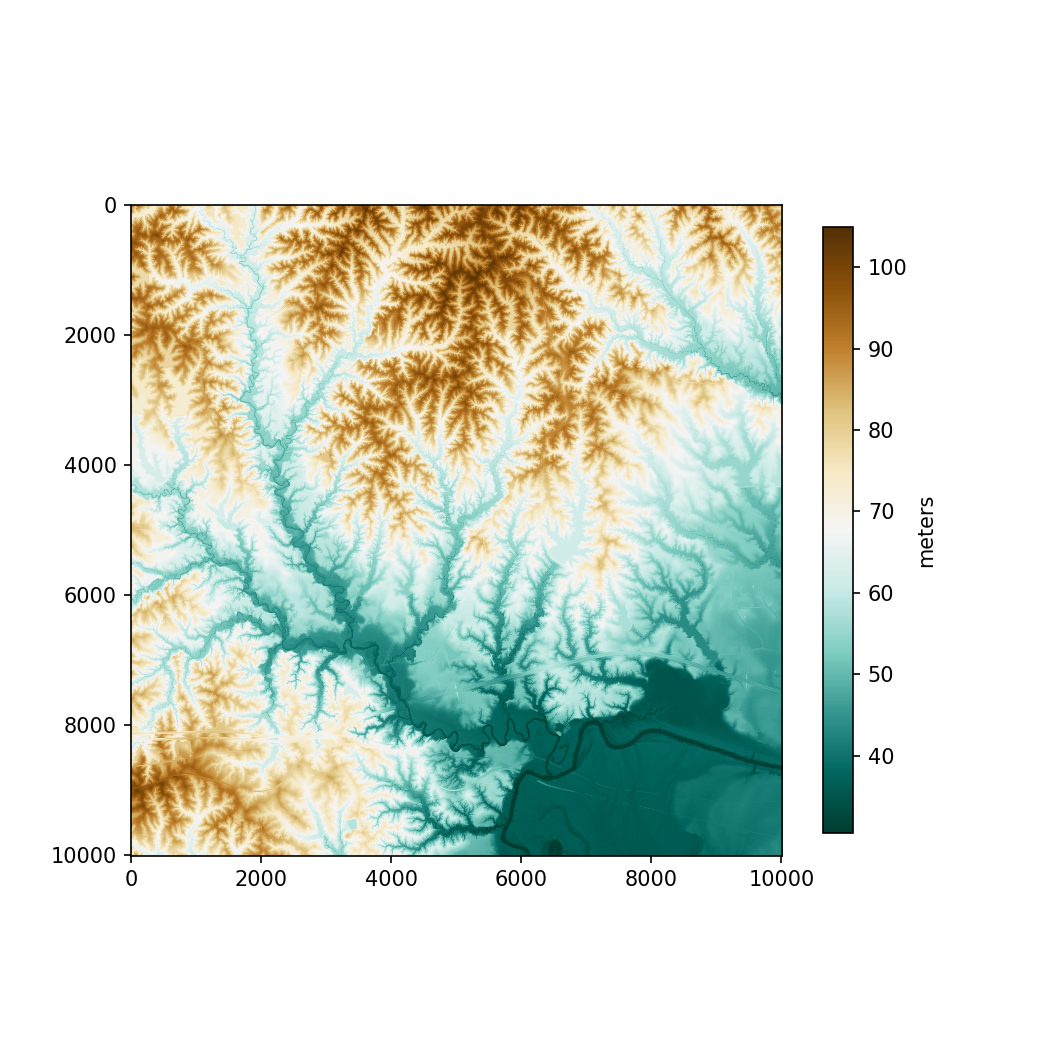

In [67]:

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(7,7))
from matplotlib import cm
#cutout = topo[(topo.shape[0]*3)//10:((topo.shape[0]*3)//10+topo.shape[0]//3),
#               topo.shape[1]//2:(topo.shape[1]//2 + topo.shape[1]//3)]
start_x = topo.shape[0]-topo.shape[0]//2
start_y = topo.shape[1]-topo.shape[1]//2
cutout = topo[start_x:(start_x+topo.shape[0]//2),
              start_y:(start_y + topo.shape[1]//2)]
plt.imshow(topo, 
           cmap=cm.BrBG_r)
cbar = plt.colorbar(shrink=0.75)
cbar.set_label('meters')

<IPython.core.display.Javascript object>


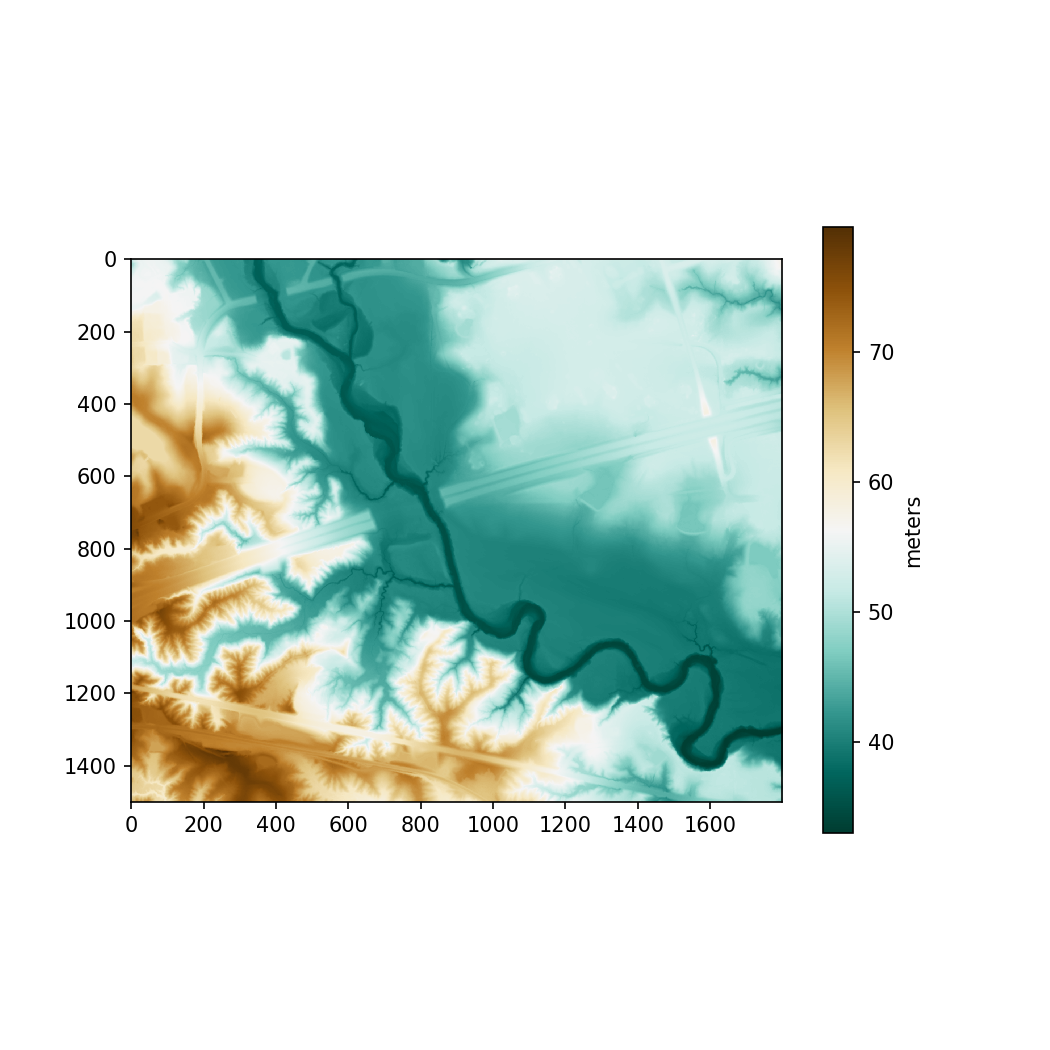

In [68]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(7,7))
from matplotlib import cm

cutout = topo[7000:8500,
              3400:5200]
plt.imshow(cutout, 
           cmap=cm.BrBG_r)
cbar = plt.colorbar(shrink=0.75)
cbar.set_label('meters')

<IPython.core.display.Javascript object>


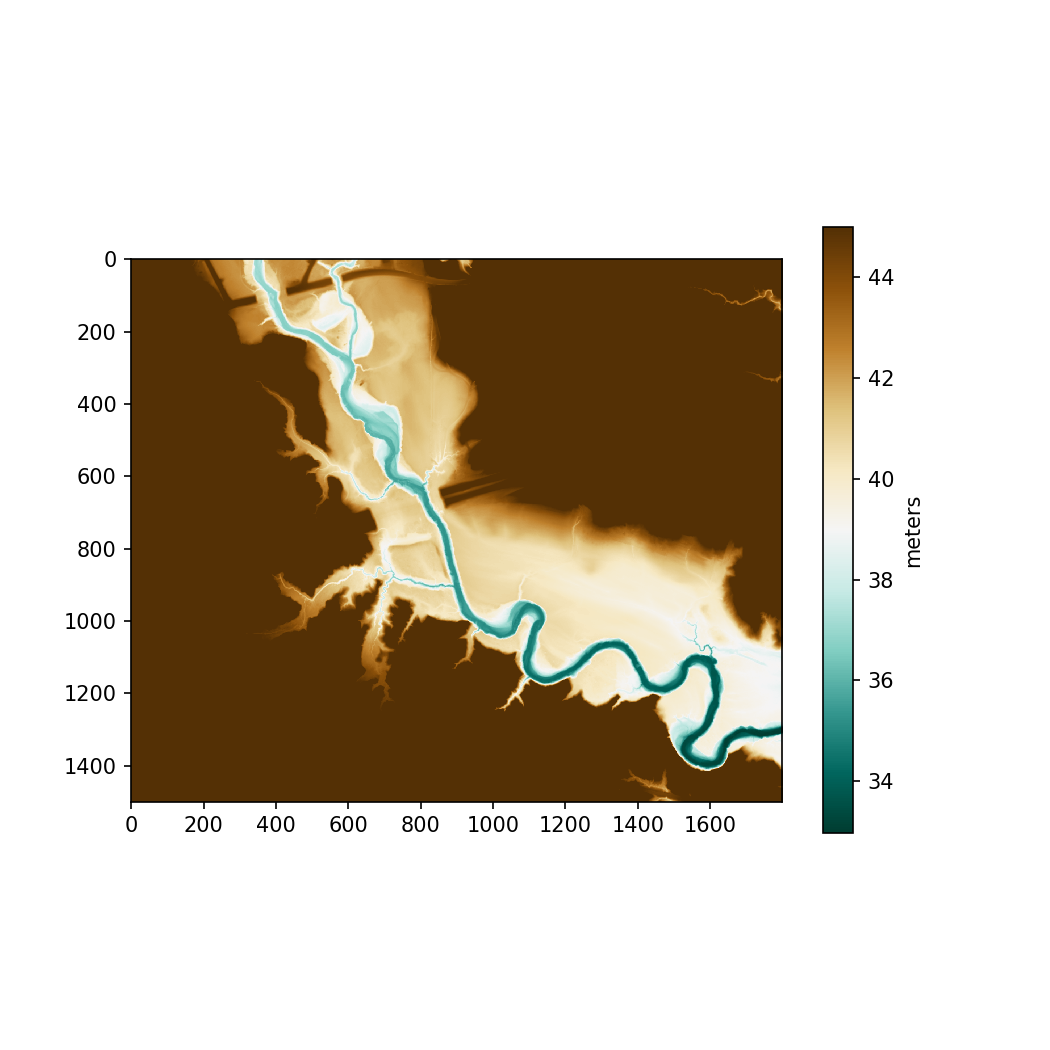

In [69]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(7,7))
from matplotlib import cm

cutout = topo[7000:8500,
              3400:5200]
plt.imshow(cutout, 
           cmap=cm.BrBG_r,
          vmin=cutout.min(),
          vmax=45)
cbar = plt.colorbar(shrink=0.75)
cbar.set_label('meters')

In [99]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
Y = np.arange(0, float(cutout.shape[0]), 1.0)#[::-1]
X = np.arange(0, float(cutout.shape[1]), 1.0)
XX, YY = np.meshgrid(X, Y)
XX = x + 3400 + XX
YY = y - 7000 - YY
print(XX.shape,YY.shape,cutout.shape)
#fig = plt.figure(figsize=(8,8))
#ax = fig.gca(projection='3d')
## Plot the surface.
#surf = ax.plot_surface(YY, XX, cutout, cmap=cm.BrBG_r,
#                       linewidth=0, antialiased=False,
#                      rcount=200,ccount=200)

(1500, 1800) (1500, 1800) (1500, 1800)


<IPython.core.display.Javascript object>


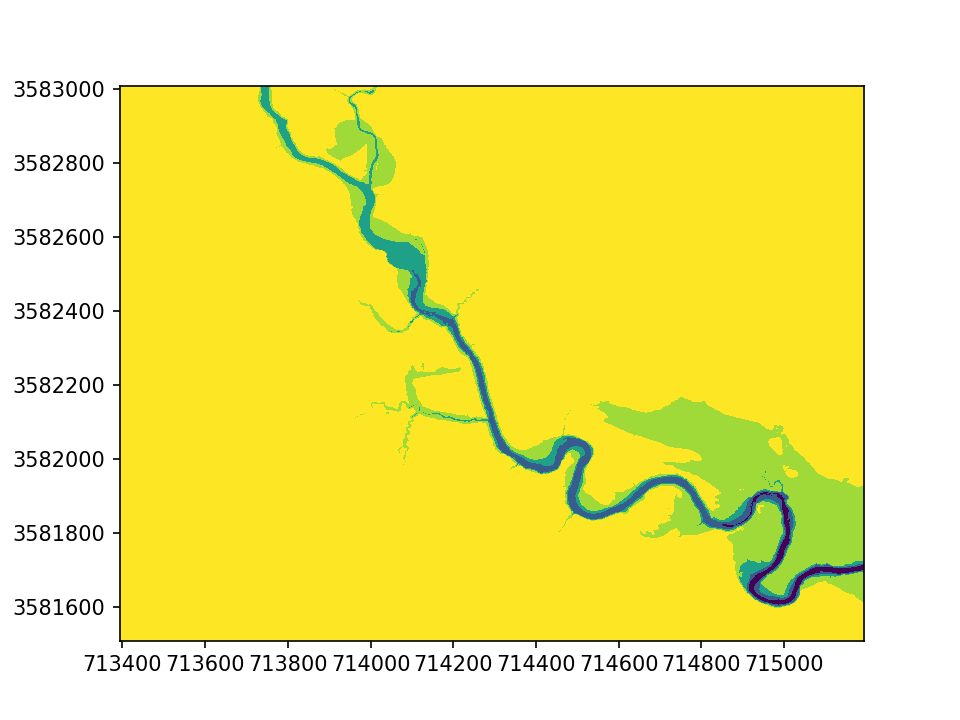

In [100]:
fig=plt.figure()
plt.contourf(XX,YY,cutout, vmin=cutout.min(),vmax=40, levels=25)

In [72]:
index = (cutout.flatten() <= 40)
XX.flatten()[index].shape

(307504,)

In [73]:
from matplotlib import tri
T = tri.Triangulation(XX.flatten()[index],YY.flatten()[index])

<IPython.core.display.Javascript object>


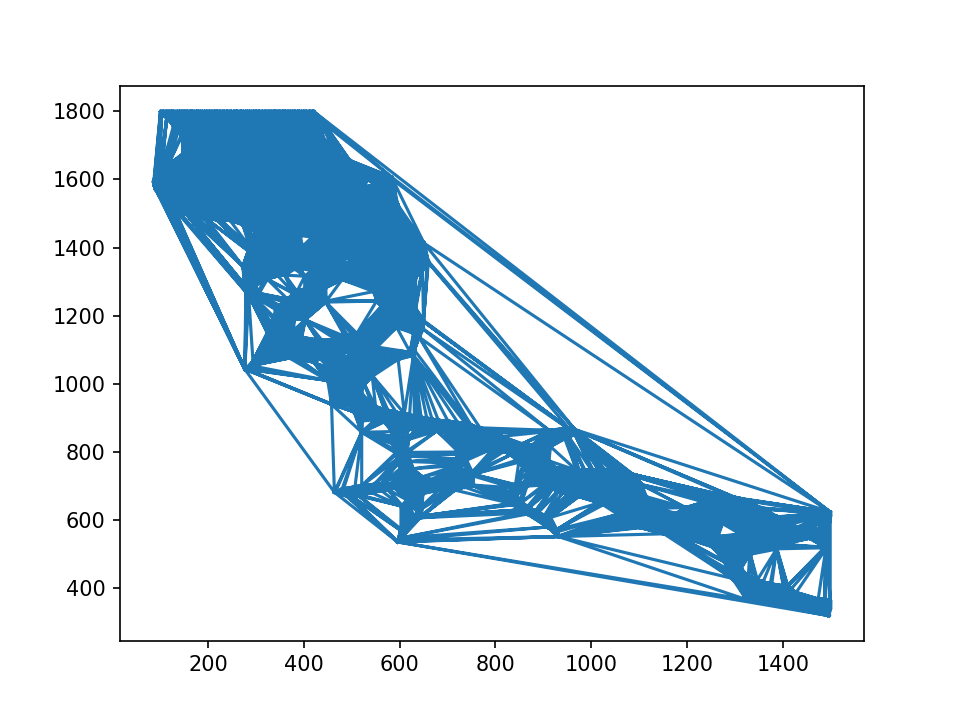

In [74]:
fig = plt.figure()
plt.triplot(T)

In [75]:
y = np.arange(0,cutout.shape[0])[::-1]
x = np.zeros(cutout.shape[0],'d')
for i in range(cutout.shape[0]):
    x[i] = cutout[i,:].argmin()

<IPython.core.display.Javascript object>


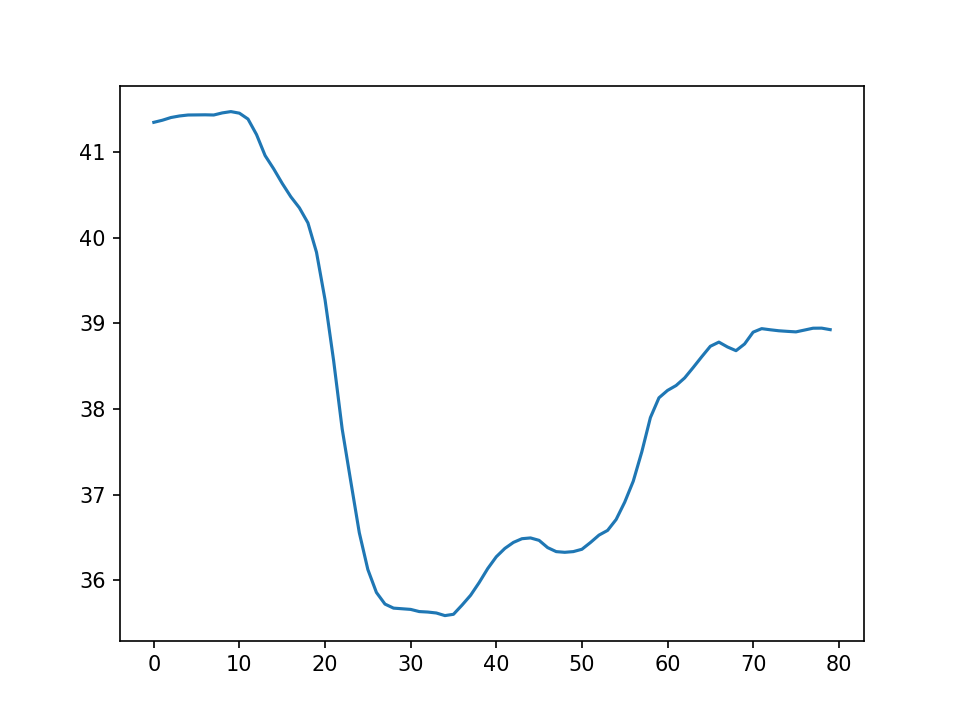

In [76]:
fig =plt.figure()
plt.plot(cutout[590,680:760])

In [77]:
np.argmin?

In [78]:
cutout[0,:].argmin

<function ndarray.argmin>

In [101]:
np.savetxt("clearcreek.csv",np.vstack([XX.flatten(),YY.flatten(),cutout.flatten()]).transpose(),delimiter=",")
np.savetxt("clearcreekclip.csv",np.vstack([XX.flatten()[index],YY.flatten()[index],cutout.flatten()[index]]).transpose(),delimiter=",")

In [80]:
XX.flat[:].shape

(2700000,)

In [81]:
XX.flatten().shape

(2700000,)

In [82]:
cutout.flatten().shape

(2700000,)

<IPython.core.display.Javascript object>


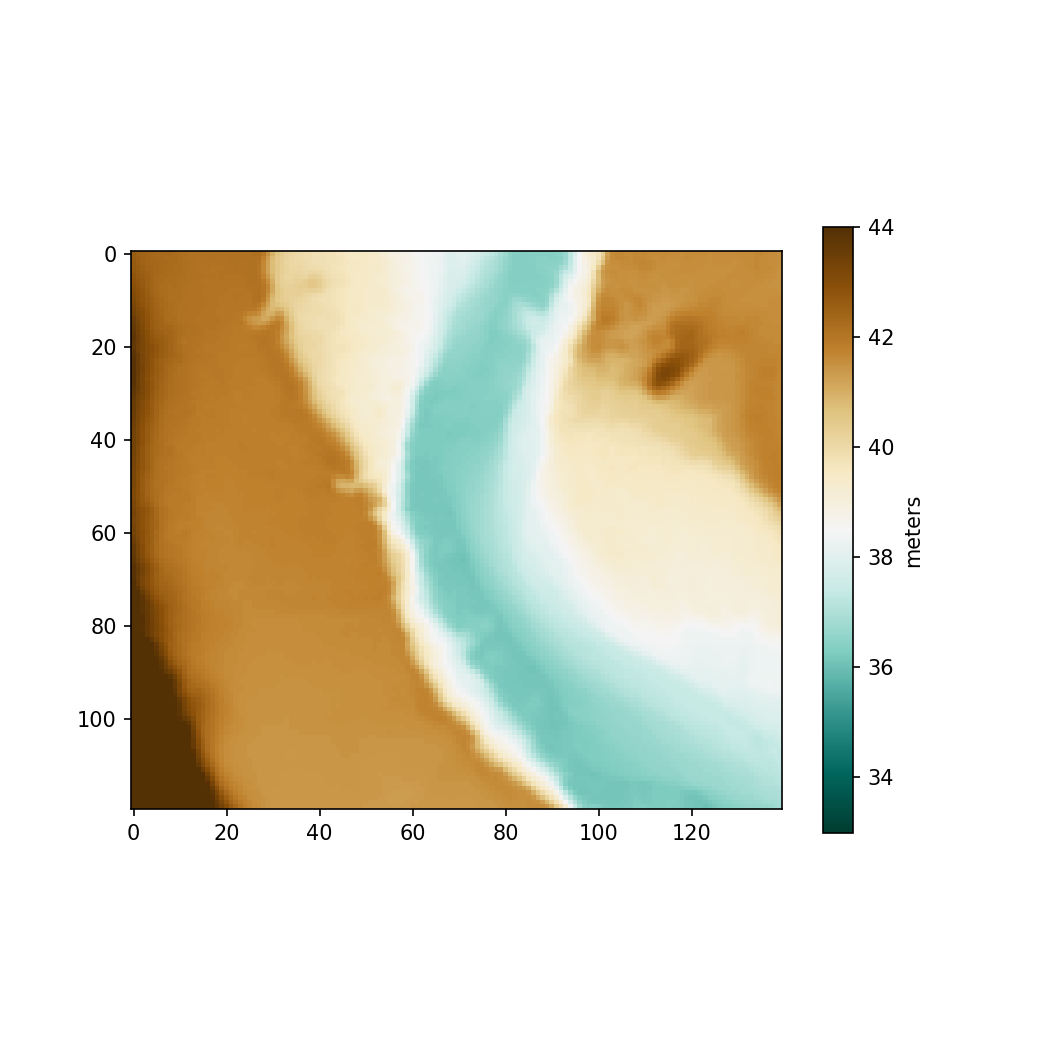

In [83]:
moundsite = cutout[320:440,
              520:660]
fig = plt.figure(figsize=(7,7))
from matplotlib import cm

plt.imshow(moundsite, 
           cmap=cm.BrBG_r,
          vmin=cutout.min(),
          vmax=44)
cbar = plt.colorbar(shrink=0.75)
cbar.set_label('meters')

In [84]:
help(plt.contourf)

Help on function contourf in module matplotlib.pyplot:

contourf(*args, data=None, **kwargs)
    Plot contours.
    
    Call signature::
    
        contour([X, Y,] Z, [levels], **kwargs)
    
    `.contour` and `.contourf` draw contour lines and filled contours,
    respectively.  Except as noted, function signatures and return values
    are the same for both versions.
    
    Parameters
    ----------
    X, Y : array-like, optional
        The coordinates of the values in *Z*.
    
        *X* and *Y* must both be 2-D with the same shape as *Z* (e.g.
        created via `numpy.meshgrid`), or they must both be 1-D such
        that ``len(X) == M`` is the number of columns in *Z* and
        ``len(Y) == N`` is the number of rows in *Z*.
    
        If not given, they are assumed to be integer indices, i.e.
        ``X = range(M)``, ``Y = range(N)``.
    
    Z : array-like(N, M)
        The height values over which the contour is drawn.
    
    levels : int or array-like, option